# **Llama-3.1-8B-Classification, Attention-LoRa & Peft**

## **Classification of actual data; 2 Labels as scale**



In [1]:
!pip install huggingface_hub
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl
!pip install pyarrow==18.1.0
!pip install evaluate
!pip install --upgrade wandb
!pip install adapter-transformers

  Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl.metadata (5.0 kB)
Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl (76.1 MB)
  Using cached accelerate-1.6.0-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-1.6.0-py3-none-any.whl (354 kB)
  Using cached peft-0.15.2-py3-none-any.whl.metadata (13 kB)
Using cached peft-0.15.2-py3-none-any.whl (411 kB)
  Using cached trl-0.17.0-py3-none-any.whl.metadata (12 kB)
  Using cached datasets-3.5.1-py3-none-any.whl.metadata (19 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached markdown_i

In [2]:
# import packages

import numpy as np
import pandas as pd
import os
import random
import evaluate
import functools # ??
from tqdm import tqdm
import bitsandbytes as bnb
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import Dataset, DatasetDict
from peft import LoraConfig, PeftConfig, prepare_model_for_kbit_training, get_peft_model

from trl import SFTTrainer
from trl import setup_chat_format

import transformers
from transformers import (AutoModelForCausalLM,
                          AutoModelForSequenceClassification,
                        AutoTokenizer,
                        AutoModel,
                        AutoConfig,
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                            Trainer,
                            DataCollatorWithPadding,
                          pipeline, 
                          logging)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix,
                            f1_score, balanced_accuracy_score)
from peft import PeftModel
from huggingface_hub import login
import matplotlib.pyplot as plt
import zipfile

In [4]:

os.getcwd()

'/home/jovyan/llama_final/Classification/two_labels/attention_LoRa'

## **Authenticate for Hugging Face**

In [7]:
# Hugging face access

with open("../../../../login/hf_key.txt", 'r') as f: 
    HF_TOKEN = str(f.read())
    
login(token = HF_TOKEN)

torch.cuda.empty_cache()
torch.cuda.is_available()
#torch.cuda.device_count()

True

In [8]:

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## **Reimport Pretrained Model**

In [6]:
# file paths
base_model = "meta-llama/Llama-3.1-8B" 
finetuned_path = "final_Llama_3.1_8B_saved_model_2labels_scale"


In [9]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4 bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

# load base model
model = AutoModelForSequenceClassification.from_pretrained(
    base_model,
    quantization_config = quantization_config
)


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.1-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Add LoRA adapter on top of it
model = PeftModel.from_pretrained(model, finetuned_path)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(finetuned_path, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id  
model.config.use_cache = False 
model.config.pretraining_pt = 1


In [11]:
# move model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

model.to(device) 

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )

In [12]:
# some checks

print("Padding token:", tokenizer.pad_token)
print("Padding token ID:", tokenizer.pad_token_id)

print("Model Configuration:")
print(model.config)

Padding token: <|end_of_text|>
Padding token ID: 128001
Model Configuration:
LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.1-8B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 128001,
  "pretraining_pt": 1,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp

# **Data**

In [13]:
subreddits = ["Ask_Politics", "Askpolitics", "PoliticalDebate", "PoliticalDiscussion", 
              "NeutralPolitics", "politics"]

subreddits_reduced = ["Ask_Politics", "Askpolitics", "PoliticalDebate", "PoliticalDiscussion", 
              "NeutralPolitics"]

subreddits_politics = ["politics"]

In [14]:
# reddit data

Ask_Pol_path = "../../../../data/Ask_Politics_new_preprocessing_com_rep.csv"
Askpol_path = "../../../../data/Askpolitics_new_preprocessing_com_rep.csv"
PolDis_path = "../../../../data/PoliticalDiscussion_new_preprocessing_com_rep.csv"
PolDeb_path = "../../../../data/PoliticalDebate_new_preprocessing_com_rep.csv"
NeuPol_path = "../../../../data/NeutralPolitics_new_preprocessing_com_rep.csv"

pol_path = "../../../../politics_preprocess/output/splitted_politics_data.zip"


In [15]:
# import data


Ask_Politics = pd.read_csv(Ask_Pol_path)
Askpolitics = pd.read_csv(Askpol_path)
PoliticalDiscussion = pd.read_csv(PolDis_path)
PoliticalDebate = pd.read_csv(PolDeb_path)
NeutralPolitics = pd.read_csv(NeuPol_path)


# politics from zip files
df_chunks = []
with zipfile.ZipFile(pol_path, 'r') as zf:
    file_list = zf.namelist()  # Get all file names in ZIP

    # Sort to maintain order (if needed)
    file_list.sort()  

    print("Files found in ZIP:", file_list)  # Debugging step

    for file in file_list:
        with zf.open(file) as f:
            df_chunk = pd.read_csv(f,  quotechar='"', encoding="utf-8")  
            df_chunks.append(df_chunk)  # Store the chunk


politics = pd.concat(df_chunks, ignore_index=True)

print(f"Successfully loaded {len(politics)} rows from {pol_path}")

Files found in ZIP: ['data_part_1.csv', 'data_part_2.csv', 'data_part_3.csv', 'data_part_4.csv', 'data_part_5.csv']
Successfully loaded 4175294 rows from ../../../../politics_preprocess/output/splitted_politics_data.zip


In [16]:
# strip quotation marks
for col in ['msg_id_parent', 'msg_id_child', 'submission_id',
            'subreddit', 
            'body_child', 'body_parent', 'submission_text',
            'author_child', 'author_parent', 'author_submission']:
    if politics[col].dtype == "object":  # Apply only to string columns
        politics[col] = politics[col].str.strip('"')


for col in ['msg_id_parent', 'msg_id_child', 'submission_id',
            'subreddit', 
            'body_child', 'body_parent', 'submission_text',
            'author_child', 'author_parent', 'author_submission']:
    if PoliticalDiscussion[col].dtype == "object":  # Apply only to string columns
        PoliticalDiscussion[col] = PoliticalDiscussion[col].str.strip('"')



In [17]:

df_dict = {"Ask_Politics" : Ask_Politics,
           "Askpolitics" : Askpolitics,
           "PoliticalDiscussion" : PoliticalDiscussion,
           "PoliticalDebate" : PoliticalDebate,
           "NeutralPolitics" : NeutralPolitics,
           "politics" : politics}



In [18]:
label_dict = {0 : 'no_disagreement', 1: 'disagree'}


## **Make Prompts**

In [19]:
# make text
model_data = {}

def create_training_data(data):

    result = []

    #for idx, row in data.iterrows():
    #    #system_prompt = """You are a classification Chatbot. Given a comment and a reply, you classify whether the reply agrees, disagrees or is neutral towards the comment. You only reply with either "agree", "disagree" or "neutral" and nothing else."""
    #    comment = row["body_parent"]
    #    reply = row["body_child"]

    #    msg_id_child = row["msg_id_child"]
    #    msg_id_parent = row["msg_id_parent"]
    #    submission_id = row["submission_id"]
        
        #label = row["label"]
        #target = row["target"]
    #    result.append({"msg_id_child" : msg_id_child, "msg_id_parent" : msg_id_parent, "submission_id" : submission_id, 'comment' : comment, 'reply': reply})
    
    result = data[["msg_id_child", "msg_id_parent", "submission_id", 'body_parent', 'body_child']]
    result = result.rename(columns = {"body_parent" : 'comment', "body_child" : 'reply'})
    return result


for subr in subreddits:
    model_data[subr] = pd.DataFrame(create_training_data(df_dict[subr]))


In [20]:
model_data["Ask_Politics"]

,msg_id_child,msg_id_parent,submission_id,comment,reply
0,c7ecs2n,c7ecp8d,14m325,Regarding Perry vs. Brown the current name of ...,Ted Olson and David Boies are extremely good ...
1,c7ecxpk,c7ecp8d,14m325,Regarding Perry vs. Brown the current name of ...,Just a quick note- I think they're calling it ...
2,c7edsp8,c7edr13,14m26x,So what was wrong with or ?,"is too broad, and the comments there are unli..."
3,c7ee4yl,c7ee45j,14m26x,We will be adhering to the AskScience style of...,The mods of AskScience are incredible strict i...
4,c7ee63a,c7ee45j,14m26x,We will be adhering to the AskScience style of...,It's probably best explained in the rule post ...
...,...,...,...,...,...
54257,kcank7h,eildsfz,b1fvxd,"Despite how many people communism has killed, ...",That's not apples-to-apples. A better comparis...
54258,kcpthf9,ffre1be,eufkoe,Here are some pretty good Conservative voices ...,Don't Walk Run Productions is highly disingenu...
54259,kd3bh9v,jqjjy5q,14ot71b,A lot of the replies here are not describing t...,"Sounds reasonable, great write-up, kudos to you!"
54260,kd4b3a5,eh3fmh4,attjcv,1. Most liberal intellectuals have better thin...,"I'm not a fan of Shaprio, but all of your poin..."


In [21]:

def make_prompt(row):

    prompt = " Comment: " + str(row["comment"]) + "; Reply: " + str(row["reply"])

    return prompt

for subr in subreddits:
    model_data[subr]['prompt'] = None
    model_data[subr]['prompt'] = model_data[subr].apply(lambda row: make_prompt(row), axis = 1)


In [22]:
model_data['politics']

,msg_id_child,msg_id_parent,submission_id,comment,reply,prompt
0,c0aeb6y,c0ae9r5,8tp50,O'Reilly was actually against FISA and Bush on...,That is what I'm looking for. Links would be a...,Comment: O'Reilly was actually against FISA a...
1,c0aee4d,c0aeds9,8tp50,Of course it's fine for Olbermann to occasiona...,As an addendum about their respective networks...,Comment: Of course it's fine for Olbermann to...
2,c0aeglj,c0aeds9,8tp50,Of course it's fine for Olbermann to occasiona...,"That's awesome and all, but do you have any ev...",Comment: Of course it's fine for Olbermann to...
3,c0aehqw,c0aeds9,8tp50,Of course it's fine for Olbermann to occasiona...,I don't understand your argument. Are you sayi...,Comment: Of course it's fine for Olbermann to...
4,c0aegcb,c0aecro,8tp50,"waaah FOX NEWS, do you people have anything be...",don't you have anything better to do than whin...,"Comment: waaah FOX NEWS, do you people have a..."
...,...,...,...,...,...,...
4175289,kfmd52k,kfkh5ib,18uirzt,Jen Sorensen Future veterans of the informatio...,Fact-checking doesnt work if no one hears you ...,Comment: Jen Sorensen Future veterans of the ...
4175290,kforzbx,kfklsb6,18uirzt,Yakima Herald-Republic and other papers in syn...,This is such a spot on interpretation of what'...,Comment: Yakima Herald-Republic and other pap...
4175291,kfp6tzv,kfmq5kr,18uirzt,Courtesy the Star Tribune's Steve Sack,Voting is not nearly that simple. In a first p...,Comment: Courtesy the Star Tribune's Steve Sa...
4175292,kfp8xh8,kfp3d4v,18uirzt,Doonesbury by Trudeau ...explain it like I'm ...,"also, try explaining why biden is better to a ...",Comment: Doonesbury by Trudeau ...explain it...


In [ ]:
# token length checks
#df['prompt_len'] = df['prompt'].apply(lambda x: len(x.split()))
#df['com_len'] = df['comment'].apply(lambda x: len(x.split()))
#df['rep_len'] = df['reply'].apply(lambda x: len(x.split()))
#df['len'] = df['com_len'] + df['rep_len']
#df['diff'] = df['prompt_len'] - df['len']
#df

# **Token Length Checks**

In [23]:
def find_longest_tokenized_text(df, tokenizer):
    # Calculate token lengths
    df['token_length'] = df['prompt'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))
    
    # Find the row with the longest tokenized input
    max_row = df.loc[df['token_length'].idxmax()]
    
    print(f"Longest tokenized text has {max_row['token_length']} tokens.")

    return max_row['token_length']

In [24]:
max_length = {}

for subr in subreddits:
    print(subr)
    
    max_length[subr] = find_longest_tokenized_text(model_data[subr], tokenizer)
    

Ask_Politics
Longest tokenized text has 3617 tokens.
Askpolitics
Longest tokenized text has 2496 tokens.
PoliticalDebate
Longest tokenized text has 2437 tokens.
PoliticalDiscussion
Longest tokenized text has 3934 tokens.
NeutralPolitics
Longest tokenized text has 5363 tokens.
politics
Longest tokenized text has 3833 tokens.


In [25]:
tokens_all = pd.DataFrame()

for subr in subreddits:
    
    tokens_all = pd.concat([tokens_all, model_data[subr]["token_length"]]).reset_index(drop = True)

tokens_all.rename(columns = {0 : "token_length"}, inplace = True)

type(tokens_all['token_length'][0])

numpy.float64

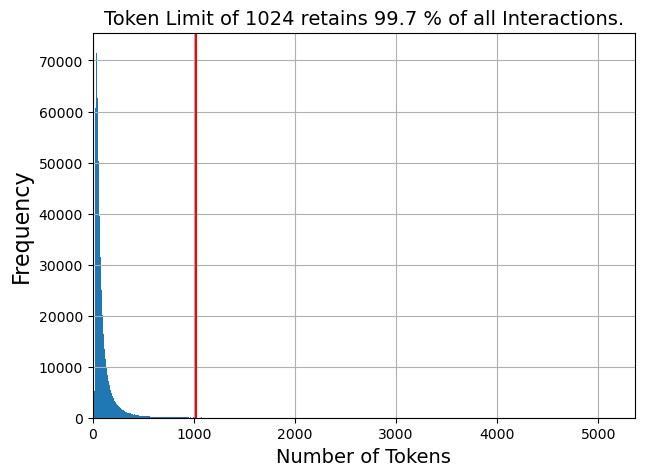

In [27]:
# Histogram of token_length

bin_edges = np.arange(0, tokens_all['token_length'].max() + 1, 1)

plt.figure(figsize=(7, 5))
plt.hist(tokens_all['token_length'], bins=bin_edges)
#plt.axvline(x = tokens_all['token_length'].mean(), color = "red")
plt.axvline(x = 1024, color = "red")
plt.xlim(0, tokens_all['token_length'].max() + 2)
plt.title(f"Token Limit of 1024 retains {round(len(tokens_all[tokens_all['token_length'] <= 1024]) / len(tokens_all) * 100, 2)} % of all Interactions.", fontsize = 14)
plt.xlabel("Number of Tokens", fontsize=14)
plt.ylabel("Frequency", fontsize=16)
plt.grid(True)
plt.savefig("TokenDistribution_Reddit.pdf")
plt.show()


In [28]:
len(tokens_all[tokens_all['token_length'] <= 1024]) / len(tokens_all)

0.9970252255788244

In [38]:
tokens_all.to_csv("output_reddit/reddit_token_len.csv", index = False)

### **Check Debagree Tokens**

In [29]:

debagree = pd.read_csv("../../../../data/debagree_new_preprocessing_com_rep.csv")
debagree = debagree[["label", "body_parent", "body_child", "msg_id_parent", "msg_id_child", "subreddit", "datetime", "exact_time"]].sort_values(by = "exact_time").reset_index(drop = True)

# keep integer labels
debagree['target'] = debagree['label']

# for readability, recode labels
int_to_label = {2: "agree", 1 : "neutral", 0 : "disagree"}
debagree.replace({"label": int_to_label}, inplace = True)

debagree

,label,body_parent,body_child,msg_id_parent,msg_id_child,subreddit,datetime,exact_time,target
0,neutral,"I live in rural Saskatchewan, Canada. We have ...",I'm in NE USA we've had 3 in two years...all e...,cnddov1,cndj2gv,climate,03/01/2015 23:18,1420327135,1
1,neutral,"I live in rural Saskatchewan, Canada. We have ...",One hundred year flood just means a one in one...,cnddov1,cndkpy7,climate,04/01/2015 00:10,1420330231,1
2,neutral,Convince her of what? That it's happening or t...,That anthropocentric climate change is actuall...,cndnlrd,cndnsxt,climate,04/01/2015 01:45,1420335952,1
3,disagree,I think this prediction is about as valid as s...,It's January. Literally no one said it would b...,cndl5x4,cndybsy,climate,04/01/2015 08:01,1420358465,0
4,disagree,"Mann hasn't been honest in decades, so I'm cur...",There have been a dozen re-constructions of Ma...,cne462t,cne89ej,climate,04/01/2015 17:45,1420393544,0
...,...,...,...,...,...,...,...,...,...
42838,neutral,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,gyo197v,gyotff1,Republican,19/05/2021 12:36,1621427788,1
42839,agree,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",gynfsu4,gyp3u39,democrats,19/05/2021 13:56,1621432578,2
42840,agree,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n...",gyn6nzm,gyp5vzw,democrats,19/05/2021 14:11,1621433471,2
42841,agree,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",gyp71o7,gyp7en6,BlackLivesMatter,19/05/2021 14:21,1621434116,2


In [30]:
# make text

def create_training_data(data):

    result = []

    for idx, row in data.iterrows():
        #system_prompt = """You are a classification Chatbot. Given a comment and a reply, you classify whether the reply disagrees with the comment, or not. You only reply with either "disagree" or "no_disagreement" and nothing else."""
        comment = row["body_parent"]
        reply = row["body_child"]
        target = row["target"]
        result.append({'comment' : comment, 'reply': reply})
    
    return result

# save data
df_debagree = pd.DataFrame(create_training_data(debagree))
df_debagree

,comment,reply
0,"I live in rural Saskatchewan, Canada. We have ...",I'm in NE USA we've had 3 in two years...all e...
1,"I live in rural Saskatchewan, Canada. We have ...",One hundred year flood just means a one in one...
2,Convince her of what? That it's happening or t...,That anthropocentric climate change is actuall...
3,I think this prediction is about as valid as s...,It's January. Literally no one said it would b...
4,"Mann hasn't been honest in decades, so I'm cur...",There have been a dozen re-constructions of Ma...
...,...,...
42838,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...
42839,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop...."
42840,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n..."
42841,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold..."


In [31]:
df_debagree['prompt'] = None

def make_prompt(row):

    prompt = "Comment: " + row["comment"] + "; Reply: " + row["reply"]

    return prompt



df_debagree['prompt'] = df_debagree.apply(lambda row: make_prompt(row), axis = 1)
df_debagree

,comment,reply,prompt
0,"I live in rural Saskatchewan, Canada. We have ...",I'm in NE USA we've had 3 in two years...all e...,"Comment: I live in rural Saskatchewan, Canada...."
1,"I live in rural Saskatchewan, Canada. We have ...",One hundred year flood just means a one in one...,"Comment: I live in rural Saskatchewan, Canada...."
2,Convince her of what? That it's happening or t...,That anthropocentric climate change is actuall...,Comment: Convince her of what? That it's happe...
3,I think this prediction is about as valid as s...,It's January. Literally no one said it would b...,Comment: I think this prediction is about as v...
4,"Mann hasn't been honest in decades, so I'm cur...",There have been a dozen re-constructions of Ma...,"Comment: Mann hasn't been honest in decades, s..."
...,...,...,...
42838,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,Comment: Not trying to spark an argument but a...
42839,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",Comment: Y'all saw Guilianis hail Mary right? ...
42840,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n...",Comment: Why don't I see ads holding Republica...
42841,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",Comment: How about ... no? This is strange. Co...


In [32]:
find_longest_tokenized_text(df_debagree, tokenizer)

Longest tokenized text has 255 tokens.


255

In [39]:
df_debagree.to_csv("output/Debagree_token_len.csv", index = False)

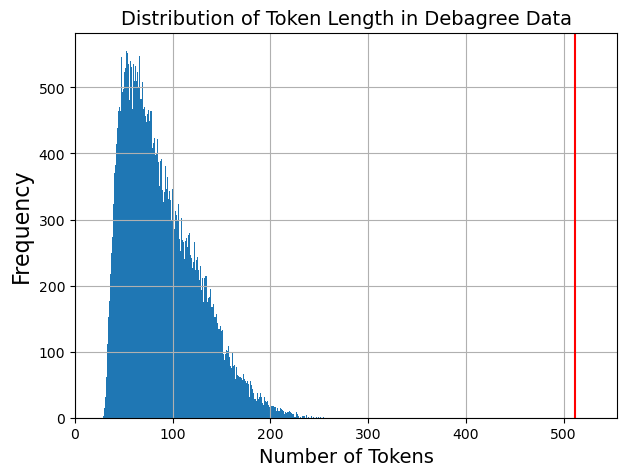

In [33]:
# Histogram of token_length

bin_edges = np.arange(0, df_debagree['token_length'].max() + 1, 1)
plt.figure(figsize=(7, 5))
plt.hist(df_debagree['token_length'], bins=bin_edges)
#plt.axvline(x = df_debagree['token_length'].mean(), color = "orange")
plt.axvline(x = 512, color = "red")
plt.xlim(0, df_debagree['token_length'].max() + 300)
plt.title(f"Distribution of Token Length in Debagree Data", fontsize = 14)
plt.xlabel("Number of Tokens", fontsize=14)
plt.ylabel("Frequency", fontsize=16)
plt.grid(True)

plt.savefig("Debagree_TokenDistribution.pdf")
plt.show()


## **Restrict Interactions**

In [92]:
model_data['Askpolitics']

,msg_id_child,msg_id_parent,submission_id,comment,reply,prompt,token_length
0,c5k2lfz,c5jo72n,x6egl,"Avoiding the snarky answers, the best way to f...","A bigger issue than the political shift would,...","Comment: Avoiding the snarky answers, the bes...",180
1,c5r2091,c5qzrah,xyno1,I don't think anyone with integrity should car...,I know I was looking more for more data based ...,Comment: I don't think anyone with integrity ...,55
2,c5yc6u2,c5ybl4k,xyno1,-America's health care was bloated and control...,This is all similar stuff to what I've found. ...,Comment: -America's health care was bloated a...,580
3,c66l5jm,c66l1tj,zpguc,Aid to Israel has increased steadily over the ...,This is bullshit politics at it's finest and w...,Comment: Aid to Israel has increased steadily...,269
4,c68eogy,c67a2lc,zs6jh,No. Just because something's legal doesn't mea...,As a state employee do you think it will conti...,Comment: No. Just because something's legal d...,85
...,...,...,...,...,...,...,...
6358,kffuy1h,kff8zac,18tpoop,He won't be elected. So you have nothing to wo...,He is not legible for office because of treaso...,Comment: He won't be elected. So you have not...,65
6359,kfgaoss,kff8zac,18tpoop,He won't be elected. So you have nothing to wo...,Do you feel the same way about the opponents P...,Comment: He won't be elected. So you have not...,84
6360,kfh5y1s,kfh4tz5,18smc4h,What the U.S. Supreme Court does with Anderson...,All good points. But my question still stands....,Comment: What the U.S. Supreme Court does wit...,618
6361,kflitpm,kfl1jy0,18ukpy4,since the obama election he's made it his poli...,When you say extremists from a point of anywhe...,Comment: since the obama election he's made i...,139


In [45]:
filtered_model_data = {}

for subr in subreddits:

    filtered_model_data[subr] = model_data[subr][model_data[subr]['token_length'] <= 1024].reset_index(drop = True)

    print(f"Removed {len(model_data[subr]) - len(filtered_model_data[subr])} in {subr}. Share: {(len(model_data[subr]) - len(filtered_model_data[subr])) / len(model_data[subr])}")



Removed 837 in Ask_Politics. Share: 0.015425159411743024
Removed 36 in Askpolitics. Share: 0.005657708628005658
Removed 92 in PoliticalDebate. Share: 0.010525111543301682
Removed 4327 in PoliticalDiscussion. Share: 0.006476255476080361
Removed 2215 in NeutralPolitics. Share: 0.04897192129117842
Removed 7242 in politics. Share: 0.001734488637207344


# **Make predictions**

In [98]:
def make_predictions(model, df_test, subreddit, thresh):

    print(subreddit)
    
    model.eval()

    # Convert summaries to a list
    sentences = df_test.prompt.tolist()
    
    # Define the batch size
    batch_size = 32  # You can adjust this based on your system's memory capacity
    
    # Initialize an empty list to store the model outputs
    all_outputs = []
    
    # Process the sentences in batches
    for i in tqdm(range(0, len(sentences), batch_size)):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]
    
      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length = 1024)
    
      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}
    
      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
          
    final_outputs = torch.cat(all_outputs, dim=0)
    probabilities = F.softmax(final_outputs, dim=1)
    
    probs_disagree = probabilities[:, 1]  # index 1 = 'disagree'
    predicted_labels = (probs_disagree > thresh).long()  # binary prediction
    certainty_scores = torch.max(probabilities, dim=1).values
    
    df_test['predictions_label_ft'] = predicted_labels.cpu().numpy()
    df_test['predictions_score_ft'] = certainty_scores.cpu().numpy()
    df_test['predictions_ft'] = df_test['predictions_label_ft'].apply(lambda l:label_dict[l])

    
    if subreddit in ['Ask_Politics', 'Askpolitics', 'NeutralPolitics', 'PoliticalDiscussion', 'PoliticalDebate']:
        df_test[['msg_id_parent', 'msg_id_child', 'submission_id', 'predictions_label_ft', 'predictions_score_ft', 
             'predictions_ft']].to_csv(f"output_reddit/{subreddit}_Llama_3.1_8B_ft_classified.csv", index = False)

   
    
    #elif subreddit == "politics":
    #    num_rows = len(df_test)
    #    chunk_size = 1_000_000  # Define chunk size (e.g., 1M rows per CSV)
        
        
        # Define output ZIP file
    #    zip_filename = "output_reddit/politics_Llama_3.1_8B_ft_classified.zip"
        #os.makedirs("output", exist_ok=True)  # Ensure output directory exists
        
        # Create ZIP file and write chunks
        
    #    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED, allowZip64=True) as zf:
    #        for i, chunk in enumerate(range(0, num_rows, chunk_size)):
    #            chunk_df = df_test.iloc[chunk:chunk + chunk_size]  # Slice the DataFrame
    #            csv_name = f"data_part_{i+1}.csv"
        
                # Convert DataFrame to CSV and store in memory
    #            csv_data = chunk_df.to_csv(index=False, quoting=1)
        
                # Write the CSV string as a new file in the ZIP archive
    #            zf.writestr(csv_name, csv_data)
            


    
    return df_test

In [99]:
# apply

make_predictions(model, filtered_model_data['Ask_Politics'], "Ask_Politics", thresh = 0.65)
make_predictions(model, filtered_model_data['Askpolitics'], "Askpolitics", thresh = 0.65)
make_predictions(model, filtered_model_data['NeutralPolitics'], "NeutralPolitics", thresh = 0.65)
make_predictions(model, filtered_model_data['PoliticalDiscussion'], "PoliticalDiscussion", thresh = 0.65)
make_predictions(model, filtered_model_data['PoliticalDebate'], "PoliticalDebate", thresh = 0.65)

Ask_Politics


100%|██████████| 1670/1670 [56:16<00:00,  2.02s/it] 


Askpolitics


100%|██████████| 198/198 [06:12<00:00,  1.88s/it]


NeutralPolitics


100%|██████████| 1345/1345 [50:39<00:00,  2.26s/it]


PoliticalDiscussion


100%|██████████| 20744/20744 [9:19:47<00:00,  1.62s/it]  


PoliticalDebate


100%|██████████| 271/271 [08:26<00:00,  1.87s/it]


,msg_id_child,msg_id_parent,submission_id,comment,reply,prompt,token_length,predictions_label_ft,predictions_score_ft,predictions_ft
0,c0d5vj9,c0d5m53,9kkf8,I think most things in the media are manufactu...,I'm going to have to agree with you entirely. ...,Comment: I think most things in the media are...,134,0,0.996582,no_disagreement
1,c0d6c7g,c0d5m53,9kkf8,I think most things in the media are manufactu...,The problem is the nature of today's mass medi...,Comment: I think most things in the media are...,211,0,0.916992,no_disagreement
2,c0d6jvc,c0d5m53,9kkf8,I think most things in the media are manufactu...,Should have taken the blue pill.\r \r FTFY,Comment: I think most things in the media are...,63,0,0.893555,no_disagreement
3,c0d7f4g,c0d5zrm,9kncm,For what it's worth - Glenn Beck has been insu...,I backed up Glenn Beck as long as I could but ...,Comment: For what it's worth - Glenn Beck has...,284,0,0.639160,no_disagreement
4,c7fpb3l,c7fp9wr,14r5kt,"I'm confused. Is it or , which doesn't seem t...",I seem to notice that as well. It said the nam...,"Comment: I'm confused. Is it or , which does...",42,0,0.994629,no_disagreement
...,...,...,...,...,...,...,...,...,...,...
8644,kfr2jzu,kfmqpen,18uokq0,Counterpoint Executing someone is infinitely p...,Anyone caught fabricating or withholding evide...,Comment: Counterpoint Executing someone is in...,127,0,0.922363,no_disagreement
8645,kfrb9ca,kfnu3qb,18upkh1,"As a potential Trump voter, I would prefer RFK...","Genuine question as a potential trump voter, a...","Comment: As a potential Trump voter, I would ...",74,1,0.967285,disagree
8646,kfrdz0h,kfor29i,18ut80y,You can see how a libertarian free market work...,A black market circumvents to usurp the regula...,Comment: You can see how a libertarian free m...,82,1,0.824707,disagree
8647,kfrgdfm,kfoqu1m,18ut80y,Libertarians tend to think we have enough time...,Libertarians tend to think we have enough tim...,Comment: Libertarians tend to think we have e...,786,0,0.937500,no_disagreement


In [ ]:
#make_predictions(model, model_data['politics'], "politics")
# estimated 50h --> wait to classify

In [ ]:
labels = df["predictions_ft"]
labels

## Politics: 

* Process in chunks and save in chunks


In [100]:
chunk_size = 750_000
politics_chunks = [filtered_model_data["politics"].iloc[i:i+chunk_size] for i in range(0, len(filtered_model_data["politics"]), chunk_size)]

In [101]:

for idx, chunk in enumerate(politics_chunks):

    df_test = make_predictions(model, chunk, "politics", thresh = 0.65)

    df_test[['msg_id_parent', 'msg_id_child', 'submission_id', 'predictions_label_ft', 'predictions_score_ft', 
             'predictions_ft']].to_csv(f"output_reddit/politics_{idx}_Llama_3.1_8B_ft_classified.csv", index = False)
        


politics


 14%|█▍        | 3233/23438 [1:17:50<7:19:59,  1.31s/it] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 23438/23438 [4:53:09<00:00,  1.33it/s]  
/tmp/ipykernel_495/1594583601.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions_label_ft'] = predicted_labels.cpu().numpy()
/tmp/ipykernel_495/1594583601.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

politics


100%|██████████| 23438/23438 [4:40:20<00:00,  1.39it/s]  
/tmp/ipykernel_495/1594583601.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions_label_ft'] = predicted_labels.cpu().numpy()
/tmp/ipykernel_495/1594583601.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions_score_ft'] = certainty_scores.cpu().numpy()
/tmp/ipykernel_495/1594583601.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

politics


 53%|█████▎    | 12396/23438 [2:32:02<1:49:05,  1.69it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 94%|█████████▍| 22003/23438 [4:04:53<11:55,  2.00it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 23438/23438 [3:33:48<00:00,  1.83it/s]  
/tmp/ipykernel_495/1594583601.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

politics


100%|██████████| 13065/13065 [2:31:35<00:00,  1.44it/s]  
/tmp/ipykernel_495/1594583601.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions_label_ft'] = predicted_labels.cpu().numpy()
/tmp/ipykernel_495/1594583601.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions_score_ft'] = certainty_scores.cpu().numpy()
/tmp/ipykernel_495/1594583601.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

# **Reimport**

In [3]:

Ask_Pol_class = "output_reddit/Ask_Politics_Llama_3.1_8B_ft_classified.csv"
Askpol_class = "output_reddit/Askpolitics_Llama_3.1_8B_ft_classified.csv"
PolDis_class = "output_reddit/PoliticalDiscussion_Llama_3.1_8B_ft_classified.csv"
PolDeb_class = "output_reddit/PoliticalDebate_Llama_3.1_8B_ft_classified.csv"
NeuPol_class = "output_reddit/NeutralPolitics_Llama_3.1_8B_ft_classified.csv"


In [4]:
Ask_Politics_class = pd.read_csv(Ask_Pol_class)
Askpolitics_class = pd.read_csv(Askpol_class)
PoliticalDiscussion_class = pd.read_csv(PolDis_class)
PoliticalDebate_class = pd.read_csv(PolDeb_class)
NeutralPolitics_class = pd.read_csv(NeuPol_class)


In [6]:
politics_classified_parts = pd.DataFrame()

for i in range(6):

    temp = pd.read_csv(f"output_reddit/politics_{i}_Llama_3.1_8B_ft_classified.csv")
    politics_classified_parts = pd.concat([politics_classified_parts, temp]).reset_index(drop = True)
    


In [7]:
#pd.read_csv(f"output_reddit/politics_1_Llama_3.1_8B_ft_classified.csv")

politics_classified_parts

,msg_id_parent,msg_id_child,submission_id,predictions_label_ft,predictions_score_ft,predictions_ft
0,c0ae9r5,c0aeb6y,8tp50,0,0.8335,no_disagreement
1,c0aeds9,c0aee4d,8tp50,0,0.9727,no_disagreement
2,c0aeds9,c0aeglj,8tp50,1,0.8610,disagree
3,c0aeds9,c0aehqw,8tp50,1,0.9966,disagree
4,c0aecro,c0aegcb,8tp50,1,0.9920,disagree
...,...,...,...,...,...,...
4168047,kfkh5ib,kfmd52k,18uirzt,0,0.9585,no_disagreement
4168048,kfklsb6,kforzbx,18uirzt,0,0.9950,no_disagreement
4168049,kfmq5kr,kfp6tzv,18uirzt,1,0.7095,disagree
4168050,kfp3d4v,kfp8xh8,18uirzt,0,0.9870,no_disagreement


In [8]:
print(len(Ask_Politics) == len(Ask_Politics_class))
print(len(Askpolitics) == len(Askpolitics_class))
print(len(PoliticalDiscussion) == len(PoliticalDiscussion_class))
print(len(PoliticalDebate) == len(PoliticalDebate_class))
print(len(NeutralPolitics) == len(NeutralPolitics_class))

NameError: name 'Ask_Politics' is not defined

In [9]:
classified_dict = {"Ask_Politics" : Ask_Politics_class,
                   "Askpolitics" : Askpolitics_class,
                   "PoliticalDiscussion" : PoliticalDiscussion_class,
                   "PoliticalDebate" : PoliticalDebate_class,
                   "NeutralPolitics" : NeutralPolitics_class,
                   "politics" : politics_classified_parts}


In [10]:
for key, value in classified_dict.items():
    print(key)
    print(len(value))

Ask_Politics
53425
Askpolitics
6327
PoliticalDiscussion
663806
PoliticalDebate
8649
NeutralPolitics
43015
politics
4168052



## **Label Shares**

In [116]:
def get_counts_and_shares(df, column):
    return df[column].value_counts().to_frame('Count').join(df[column].value_counts(normalize=True).to_frame('%')).reset_index()


In [117]:
def get_label_shares(df, label_col, valid_labels, subreddit):

    share = len(df[df[label_col].isin(valid_labels)]) / len(df)
    print(f"Valid Share of labels in {subreddit}: {share}")

    return df[label_col].value_counts().to_frame('Count').join(df[label_col].value_counts(normalize=True).to_frame('%')).reset_index()

    


In [119]:
label_shares = {}

for subr in subreddits:
    label_shares[subr] = get_label_shares(classified_dict[subr], 'predictions_ft', ['disagree', 'no_disagreement'], subr)

Valid Share of labels in Ask_Politics: 1.0
Valid Share of labels in Askpolitics: 1.0
Valid Share of labels in PoliticalDebate: 1.0
Valid Share of labels in PoliticalDiscussion: 1.0
Valid Share of labels in NeutralPolitics: 1.0
Valid Share of labels in politics: 1.0


In [120]:
label_shares['Ask_Politics']

,predictions_ft,Count,%
0,no_disagreement,34141,0.639045
1,disagree,19284,0.360955


In [121]:
label_shares['Askpolitics']

,predictions_ft,Count,%
0,no_disagreement,3811,0.602339
1,disagree,2516,0.397661


In [122]:
label_shares['PoliticalDiscussion']

,predictions_ft,Count,%
0,no_disagreement,414084,0.623803
1,disagree,249722,0.376197


In [123]:
label_shares['PoliticalDebate']

,predictions_ft,Count,%
0,disagree,4570,0.528385
1,no_disagreement,4079,0.471615


In [124]:
label_shares['NeutralPolitics']

,predictions_ft,Count,%
0,no_disagreement,28768,0.66879
1,disagree,14247,0.33121


In [125]:
label_shares['politics']

,predictions_ft,Count,%
0,no_disagreement,3213962,0.771095
1,disagree,954090,0.228905


In [137]:
val_data_e = pd.read_excel("../../../Validation/data/labeled_E_2cat.xlsx")
val_data_e.drop(columns = ["index"], inplace = True)
val_data_e.rename(columns = {"label": "label_e"}, inplace = True)

val_data_e


for col in ['msg_id_parent', 'msg_id_child', 'submission_id',
            'subreddit', 
            'body_child', 'body_parent', 'submission_text']:
    if val_data_e[col].dtype == "object":  # Apply only to string columns
        val_data_e[col] = val_data_e[col].str.strip('"')

val_data_e

,submission_id,msg_id_parent,msg_id_child,submission_text,body_parent,body_child,subreddit,label_e
0,8we2i8,e2gbshk,e2go5cs,So walkaway has gone viral whatever that means...,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics,disagree
1,17p478l,k8h1qxn,k8ivjmx,Question in a state like Mississippi thats oft...,You talk like Mississippi has the same infrast...,"Wow lol, was it that obvious that I'm from New...",Askpolitics,no_disagreement
2,181o366,kaf8us2,kahj2cn,"In the United States, there is a lot about wha...",We need to read more classic literature,May I ask what you consider the classics?,PoliticalDebate,no_disagreement
3,18rqy2g,kf37doz,kf54umb,Federal Revenue FY 2022 Budget -- Income Taxe...,Everything the government does that isnt makin...,So you would immediately remove Medicare and S...,PoliticalDebate,no_disagreement
4,4dgyfc,d1qsqkm,d1r17xo,"In an appearance on CNN's New Day, Jeff Weaver...",Funny math It's still math. It's unlikely that...,Weaver is playing cute with the super delegate...,PoliticalDiscussion,no_disagreement
5,18fxb9q,kd28j8o,kdb3j9u,Milei has promised shock therapy as a way to a...,Why would he reduce capital expenditures or bl...,Argentinian government debt is basically worth...,PoliticalDiscussion,no_disagreement
6,xqo2u,c5or5ik,c5p0n4r,"Truth be told, it's not any individual's fault...",You folks will enjoy r.politics much more when...,Same thing is on - it takes you an hour to ge...,politics,no_disagreement
7,17phvl2,k87wrac,k89o4tn,There's a lot going on in the right now that h...,"IMHO Republicans will gain seats in the House,...",Republicans are showing they can govern. I don...,PoliticalDebate,disagree
8,2p7xdk,cmu9elu,cmuk9pu,I'm sure you could have always found 20 of the...,"The American Right has perpetrated this, throu...",Play spot the Fasci next time you're looking a...,politics,no_disagreement
9,1ov3n2,ccw1rty,ccw2pn9,This fascinating article about a recent Yale s...,I don't find this particularly disturbing and ...,To add to what you said and expand on the arti...,NeutralPolitics,no_disagreement


In [138]:

get_label_shares(val_data_e[val_data_e['subreddit'] == 'Ask_Politics'], 'label_e', ['disagree', 'no_disagreement'], "Ask_Politics")

Valid Share of labels in Ask_Politics: 1.0


,label_e,Count,%
0,no_disagreement,8,0.8
1,disagree,2,0.2


In [139]:
get_label_shares(val_data_e[val_data_e['subreddit'] == 'Askpolitics'], 'label_e', ['disagree', 'no_disagreement'], "Askpolitics")

Valid Share of labels in Askpolitics: 1.0


,label_e,Count,%
0,no_disagreement,7,0.7
1,disagree,3,0.3


In [140]:
get_label_shares(val_data_e[val_data_e['subreddit'] == 'PoliticalDebate'], 'label_e', ['disagree', 'no_disagreement'], "PoliticalDebate")

Valid Share of labels in PoliticalDebate: 1.0


,label_e,Count,%
0,no_disagreement,8,0.8
1,disagree,2,0.2


In [141]:
get_label_shares(val_data_e[val_data_e['subreddit'] == 'PoliticalDiscussion'], 'label_e', ['disagree', 'no_disagreement'], "PoliticalDiscussion")

Valid Share of labels in PoliticalDiscussion: 1.0


,label_e,Count,%
0,no_disagreement,9,0.9
1,disagree,1,0.1


In [142]:
get_label_shares(val_data_e[val_data_e['subreddit'] == 'NeutralPolitics'], 'label_e', ['disagree', 'no_disagreement'], "NeutralPolitics")

Valid Share of labels in NeutralPolitics: 1.0


,label_e,Count,%
0,no_disagreement,7,0.7
1,disagree,3,0.3


In [143]:
get_label_shares(val_data_e[val_data_e['subreddit'] == 'politics'], 'label_e', ['disagree', 'no_disagreement'], "politics")

Valid Share of labels in politics: 1.0


,label_e,Count,%
0,no_disagreement,8,0.8
1,disagree,2,0.2
